# <font style="color:blue">Optimization Algorithms</font>

We now know the theory behind a few optimizers (Gradient Descent, Gradient Descent with Momentum, RMSprop, and  Adam). Let's see how to use these optimizers in PyTorch.

`torch.optim` is a PyTorch package where various optimization algorithms are implemented. You should check out all the optimizers and their parameters available in the package [here](https://pytorch.org/docs/stable/optim.html).

We will use the same LeNet Network with the Fashion MNIST dataset  to illustrate the convergence of different optimization algorithms.

Specifically, we will see in `Steps 10 to 13`, how the different optimizers are initialized and used to train the network. We will use the same learning rate for all optimizers.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [3]:
import os
import time

from typing import Iterable, List, Tuple
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# <font style="color:blue">1. LeNet Architecture</font>
This is the same architecture we had covered in the previous week.

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [5]:
lenet_model = LeNet()
print(lenet_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# <font style="color:blue">3. Get Fashion MNIST Data</font>

In [6]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify for yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

In [7]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>
Note that we are setting a learning rate of 0.001 for our tests.

In [19]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 64  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 30  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.001  # determines the speed of network's weights update
    log_interval: int = 500  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "./data"  # folder to save Fashion MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

In [20]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch.

In [21]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> Tuple[float, float]:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

#         if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
#             print(
#                 'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
#                     epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
#                 )
#             )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    print('\nEpoch: {} Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))

    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

In [22]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> Tuple[float, float]:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc.
1. Load the data using dataloaders.
1. For each epoch, call train function. 
1. Set up variables to track loss and accuracy and start training.



In [23]:
def main(model, optimizer, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

# <font style="color:blue">10. Training using SGD (Gradient Descent)</font>

**Gradient descent update rule:**

$$
W_t = W_{t-1} -\alpha g_{t-1}
$$

where,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

and,


$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n} 
         \end{bmatrix}
$$

**For stochastic gradient descent update, we use the following method in PyTorch:** 


```
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```
- **`params`** (iterable) – iterable of parameters to optimize or dicts defining parameter groups. `model.parameters()` gives iterable model parameters. [Required]

- **`lr`** (python:float) – learning rate [Required]

- `momentum` (python:float, optional) – momentum factor (default: 0)

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: 0)

- `dampening` (python:float, optional) – dampening for momentum (default: 0)

- `nesterov` (bool, optional) – enables Nesterov momentum (default: False)

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate
)


model, train_loss_sgd, train_acc_sgd, test_loss_sgd, test_acc_sgd = main(model, optimizer)



# <font style="color:blue">11. Training using SGD with Momentum</font>

**Gradient descent with momentun update rule:**

$$
\begin{align}
v_t &= \beta v_{t-1} + (1 - \beta) g_{t-1} \\
\\
W_t &= W_{t-1} - \alpha v_t \\
\end{align}
$$


**In PyTorch, we use `torch.optim.SGD` with non-zero momentum value.**

In the following training, we will use $\beta = 0.9$. Here $\beta$ is momentum.


In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    # to use momentum, changed default value 0 to 0.9
    momentum = 0.9
)


model, train_loss_sgd_momentum, train_acc_sgd_momentum, test_loss_sgd_momentum, test_acc_sgd_momentum = main(
    model, 
    optimizer)



# <font style="color:blue">12. Training using RMSProp</font>

**RMSProp update rule:**

$$
\begin{align}
s_t &= \beta s_{t-1} + (1 - \beta) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {g_{t-1}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

**For RMSProp weight update, we use the following method in PyTorch:** 

```
torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
```
- **`params`** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

- `lr` (python:float, optional) – learning rate (default: 1e-2). $\alpha$ is learning rate in the `RMSProp` update rule.

- `momentum` (python:float, optional) – momentum factor (default: 0)

- `alpha` (python:float, optional) – smoothing constant (default: 0.99). $\beta$ is smothing constant in the `RMSProp` update rule.

- `eps` (python:float, optional) – term added to the denominator to improve numerical stability (default: 1e-8). This $\epsilon$ is the `RMSProp` update rule.

- `centered` (bool, optional) – if True, compute the centered RMSProp, the gradient is normalized by an estimation of its variance

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: 0)



Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop).

In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.RMSprop(
    model.parameters(),
    lr=train_config.learning_rate
)


model, train_loss_rms_prop, train_acc_rms_prop, test_loss_rms_prop, test_acc_rms_prop = main(model, optimizer)



# <font style="color:blue">13. Training using Adam (Momentum + RMSProp)</font>

**Adam update rule:**
$$
\begin{align}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) g_{t-1} \\
\\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {v_{t}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

**For Adam weight update, we use the following method in PyTorch:**

```
torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
```
- **`params`** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

- `lr` (python:float, optional) – learning rate (default: `1e-3`). $\alpha$ is learning rate in Adam update rule.

- `betas` (Tuple[python:float, python:float], optional) – coefficients used for computing running averages of gradient and its square (default: `(0.9, 0.999)`). In Adam update rule, first value of tuple is $\beta_1$ and second value is $\beta_2$

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: `0`)

- `amsgrad` (boolean, optional) – whether to use the AMSGrad variant of this algorithm from the paper [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ) (default: False)




Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=train_config.learning_rate
)


model, train_loss_adam, train_acc_adam, test_loss_adam, test_acc_adam = main(model, optimizer)



# <font style="color:blue">14. Plot Loss Curves</font>

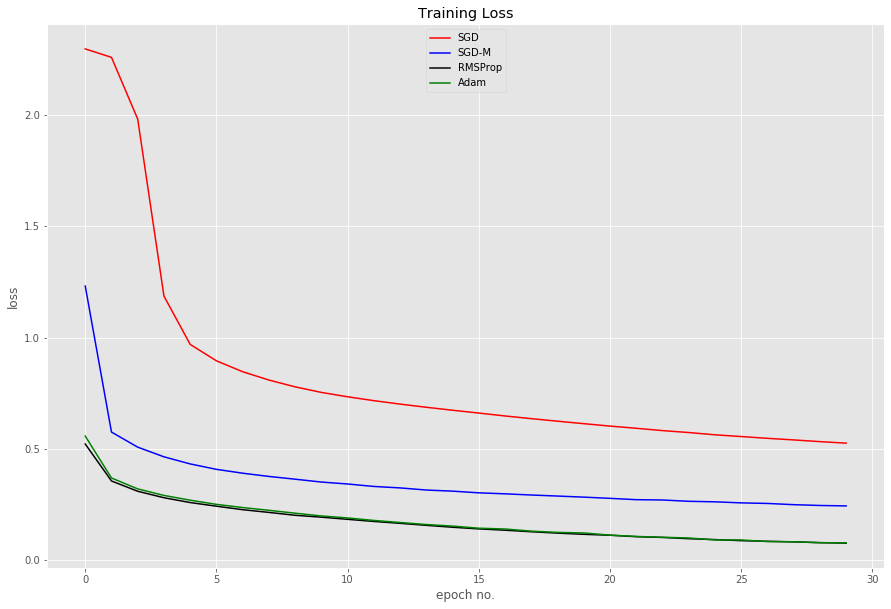

In [28]:
# Plot loss
plt.rcParams["figure.figsize"] = (15, 10)
x = range(len(train_loss_sgd))

plt.figure
plt.plot(x, train_loss_sgd, 'r', label="SGD")

plt.plot(x, train_loss_sgd_momentum, 'b', label="SGD-M")

plt.plot(x, train_loss_rms_prop, 'k', label="RMSProp")

plt.plot(x, train_loss_adam, 'g', label="Adam")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper center')
plt.title('Training Loss')
plt.show()

# <font style="color:blue">Conclusion</font>
 We can see that the loss decreases in the following order: Adam = RMSProp > SGD-Momentum > SGD 

# <font style="color:blue">Exercise</font>
1. Change the Learning rate of the experiment to 0.0001 or 0.01 and see how the curves vary.
1. See what happens when you choose the default learning rates for the optimizers.
1. See what happens when you change other parameters of the optimizers. For example : momentum, $\epsilon$, $\alpha$, $\beta$.